# ML_Modeling

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import random
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import tree
import scipy.stats as stat
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier




In [33]:
#import local modules
import Graphs
from Decision_tree import handler
from Decision_tree import DecisionTreesModel

from XGB import boost
from logistic_regression import Logistic

In [5]:
df= pd.read_csv("../data/AdSmartABdata_o.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [6]:
#Users who actually responded yes/no to the question of awareness
answered_df = df.copy(deep=True)
answered_df = answered_df[answered_df['yes'] == 1].append(answered_df[answered_df['no'] == 1])
answered_df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
45,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
65,023ec7b5-cb8f-49a5-995f-e0d7c2f702e5,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1,0
89,02efdb70-8596-4f3f-b0b2-b91e194f61f7,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1,0


In [7]:
control_df = answered_df[answered_df['experiment'] == 'control']
exposed_df = answered_df[answered_df['experiment'] == 'exposed']

In [8]:
all_yes_df = answered_df[answered_df['yes'] == 1].append(exposed_df[exposed_df['yes'] == 1])
all_yes_df = all_yes_df.drop(['yes','no'], axis = 1)
all_yes_df['response'] = 1
#All users who answered no
all_no_df = answered_df[answered_df['no'] == 1].append(exposed_df[exposed_df['no'] == 1])
all_no_df = all_no_df.drop(['yes','no'], axis = 1)
all_no_df['response'] = 0
#Final Combined dataframe will be
combined_df = all_yes_df.append(all_no_df)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,e895db75-d021-44cd-89c0-583abc0a67b0,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile WebView,0
1,6f1df2d5-1dff-4c1a-949d-2217c81a0fd6,exposed,2020-07-03,10,Samsung SM-A405FN,6,Chrome Mobile WebView,0
2,3ba61e8e-99e0-46a8-b168-a7de44391ecc,control,2020-07-05,8,Samsung SM-G770F,6,Samsung Internet,0
3,7a93f027-c1fd-43a6-96fd-5d3cd6b57a43,exposed,2020-07-04,8,Generic Smartphone,6,Chrome Mobile WebView,0
4,0e08a41e-2430-428f-ba2f-4d687ca8f377,exposed,2020-07-09,8,Generic Smartphone,6,Chrome Mobile,0


# Encoding and Transforming

In [9]:
def encode_labels(df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    response_encoder = preprocessing.LabelEncoder()
    
    combined_df['date'] = date_encoder.fit_transform(combined_df['date'])
    combined_df['device_make'] = device_encoder.fit_transform(combined_df['device_make'])
    combined_df['browser'] = browser_encoder.fit_transform(combined_df['browser'])
    combined_df['experiment'] = experiment_encoder.fit_transform(combined_df['experiment'])
    combined_df['browser'] = response_encoder.fit_transform(combined_df['browser'])
    combined_df['response'] = response_encoder.fit_transform(combined_df['response'])


    
    return combined_df

## split the data to platform and browser based


In [10]:
def feature_data(combined_df):
    browser_df = combined_df[["experiment", "hour", "date", 'device_make', 'browser', 'response']]
    platform_df = combined_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'response']]
                                  
    return browser_df, platform_df


In [11]:
def save_encoded_df(encoded_df):
    
    browser_df, platfrom_df = feature_data(encoded_df)
    browser_df.to_csv('../data/browser.csv', index=False)
    platfrom_df.to_csv('../data/platform.csv', index=False)

In [38]:
encoded_df = encode_labels(combined_df)
save_encoded_df(encoded_df)

In [40]:
combined_df

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,e895db75-d021-44cd-89c0-583abc0a67b0,0,0,15,13,6,2,0
1,6f1df2d5-1dff-4c1a-949d-2217c81a0fd6,1,0,10,47,6,2,0
2,3ba61e8e-99e0-46a8-b168-a7de44391ecc,0,2,8,60,6,7,0
3,7a93f027-c1fd-43a6-96fd-5d3cd6b57a43,1,1,8,13,6,2,0
4,0e08a41e-2430-428f-ba2f-4d687ca8f377,1,6,8,13,6,1,0
...,...,...,...,...,...,...,...,...
1895,64beba58-5f3b-4de3-8c81-0cb5ece67c5d,1,1,9,13,6,1,1
1896,b4f2fe23-ce2e-4b8f-ae93-4314aac8866b,1,7,6,13,6,1,1
1897,8aca8139-c391-4b39-b59c-17935644ea8f,1,3,10,19,6,2,1
1898,6bbc74ed-546f-48b5-bf91-cb8888e96286,1,2,9,86,6,7,1


# ML modeling

In [12]:
#define train and split testing function and best random state to produce same result for different run
def split_train_test(X, y, test_size=0.1):
    return train_test_split(X, y, test_size=test_size, random_state=42)

#### Platform

In [41]:
browser_df = combined_df[["experiment", "hour", "date", 'device_make', 'browser', 'response']]
platform_df = combined_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'response']]

In [14]:
#reading the encoded data from saved split data
platform_df= platform_df.to_csv("../data2/AdSmartABdata_o.csv")


In [15]:
path = 'data2/AdSmartABdata_o.csv'
repo = 'https://github.com/dagmawiii03/Ab_Hypothesis_Testing'
rev = 'platform-v1'
data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
collected_data = pd.read_csv(data_url)

In [39]:
platform_df 

,experiment,hour,date,device_make,platform_os,response
0,control,15,2020-07-03,Generic Smartphone,6,0
1,exposed,10,2020-07-03,Samsung SM-A405FN,6,0
2,control,8,2020-07-05,Samsung SM-G770F,6,0
3,exposed,8,2020-07-04,Generic Smartphone,6,0
4,exposed,8,2020-07-09,Generic Smartphone,6,0
...,...,...,...,...,...,...
1895,exposed,9,2020-07-04,Generic Smartphone,6,1
1896,exposed,6,2020-07-10,Generic Smartphone,6,1
1897,exposed,10,2020-07-06,I3312,6,1
1898,exposed,9,2020-07-05,Samsung SM-J530F,6,1


#### browser

In [16]:
browser_df= browser_df.to_csv("../data2/AdSmartABdata_o.csv")


In [17]:
path = 'data2/AdSmartABdata_o.csv'
repo = 'https://github.com/dagmawiii03/Ab_Hypothesis_Testing'
rev = 'browser-v1'
data_url = dvc.api.get_url(path=path, repo=repo, rev=rev)
collected_data = pd.read_csv(data_url)

In [18]:
browser_df= pd.read_csv("../data/browser.csv")


## Decision Tree Model

In [19]:
def read_model(self, file_name):
    with open(f"../models/{file_name}.pkl", "rb") as f:
        self.logger.info(f"Model loaded from {file_name}.pkl")
        return pickle.load(f)

def write_model(self, file_name):
      with open(f"../models/{file_name}.pkl", "wb") as f:
          self.logger.info(f"Model dumped to {file_name}.pkl")
          pickle.dump(model, f)

### using platform

In [42]:
#using platform df

X = platform_df.drop('response', axis=1) #prediction features
y = platform_df['response'] #target feature


#X = platform_df[feature_cols]
#y = platform_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [43]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)

step 0: Validation Accuracy of DecisionTreesModel is: 0.515
step 0: Validation Loss of DecisionTreesModel is: 0.697

step 1: Validation Accuracy of DecisionTreesModel is: 0.561
step 1: Validation Loss of DecisionTreesModel is: 0.662

step 2: Validation Accuracy of DecisionTreesModel is: 0.532
step 2: Validation Loss of DecisionTreesModel is: 0.684

step 3: Validation Accuracy of DecisionTreesModel is: 0.585
step 3: Validation Loss of DecisionTreesModel is: 0.644

step 4: Validation Accuracy of DecisionTreesModel is: 0.579
step 4: Validation Loss of DecisionTreesModel is: 0.649



step 1: Test Accuracy of DecisionTreesModel is: 0.542
Test Metrics
              precision    recall  f1-score   support

           0       0.83      0.55      0.66       154
           1       0.21      0.53      0.30        36

    accuracy                           0.54       190
   macro avg       0.52      0.54      0.48       190
weighted avg       0.71      0.54      0.59       190

Loss on test data is: 0.677



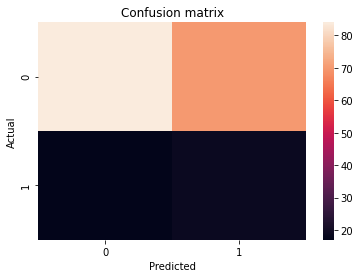

In [44]:
#Evaluating the model
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

### Feature Importance

In [45]:
#quantifing the importance of the features(columns)
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.374402
2,date,0.046269
3,device_make,0.579329
4,platform_os,0.000000


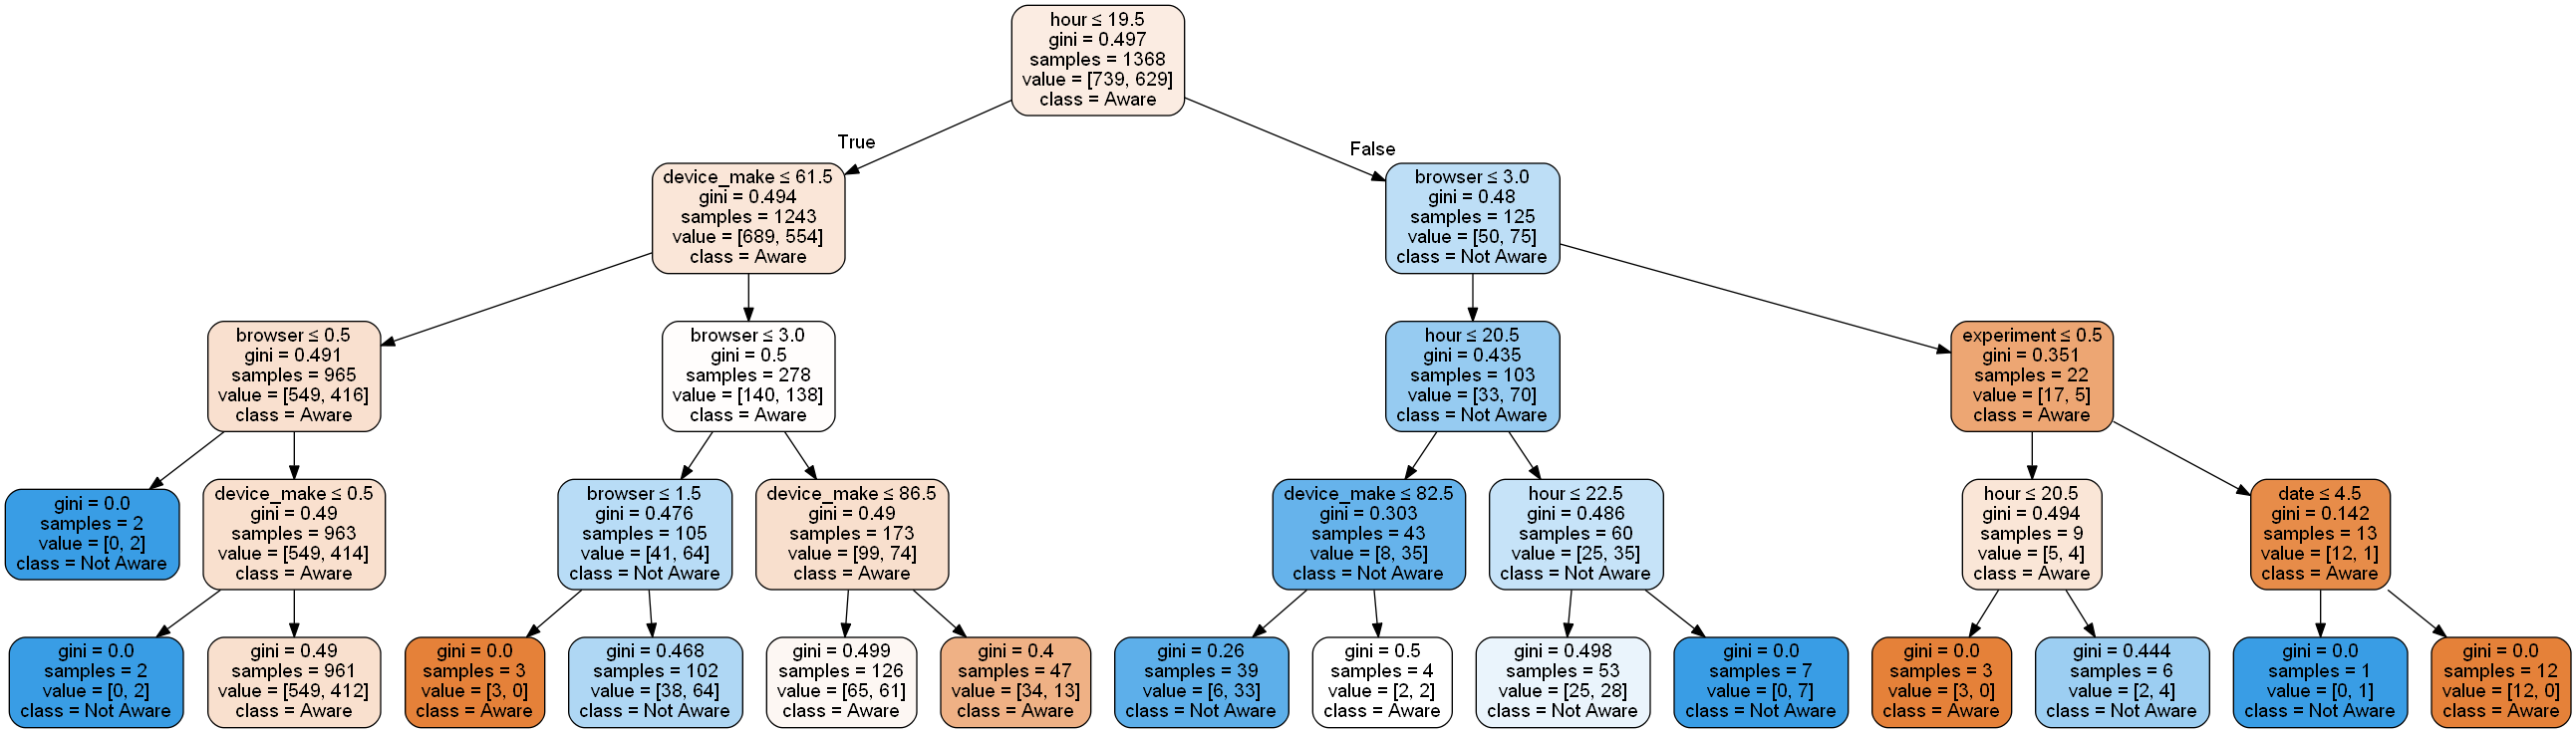

In [78]:
#visualization
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('platform_AbTestDecisionTree.png')
Image(graph.create_png())

### using Browser

In [47]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [48]:
decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

folds = 5
clf, acc_arr, loss_arr = decisionTreesModel.train(folds)

step 0: Validation Accuracy of DecisionTreesModel is: 0.523
step 0: Validation Loss of DecisionTreesModel is: 0.690

step 1: Validation Accuracy of DecisionTreesModel is: 0.570
step 1: Validation Loss of DecisionTreesModel is: 0.656

step 2: Validation Accuracy of DecisionTreesModel is: 0.567
step 2: Validation Loss of DecisionTreesModel is: 0.658

step 3: Validation Accuracy of DecisionTreesModel is: 0.596
step 3: Validation Loss of DecisionTreesModel is: 0.635

step 4: Validation Accuracy of DecisionTreesModel is: 0.602
step 4: Validation Loss of DecisionTreesModel is: 0.631



step 1: Test Accuracy of DecisionTreesModel is: 0.547
Test Metrics
              precision    recall  f1-score   support

           0       0.90      0.54      0.68       167
           1       0.15      0.57      0.23        23

    accuracy                           0.55       190
   macro avg       0.52      0.56      0.46       190
weighted avg       0.81      0.55      0.62       190

Loss on test data is: 0.673
Test accuracy on test data is: 0.547



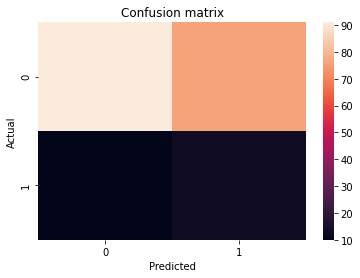

In [49]:
#evaluating the model
test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print(f"Test accuracy on test data is: {test_acc:.3f}")
print()

In [50]:
#quantifing the importance of the features(columns)
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.037633
1,hour,0.330112
2,date,0.048359
3,device_make,0.182371
4,browser,0.401525


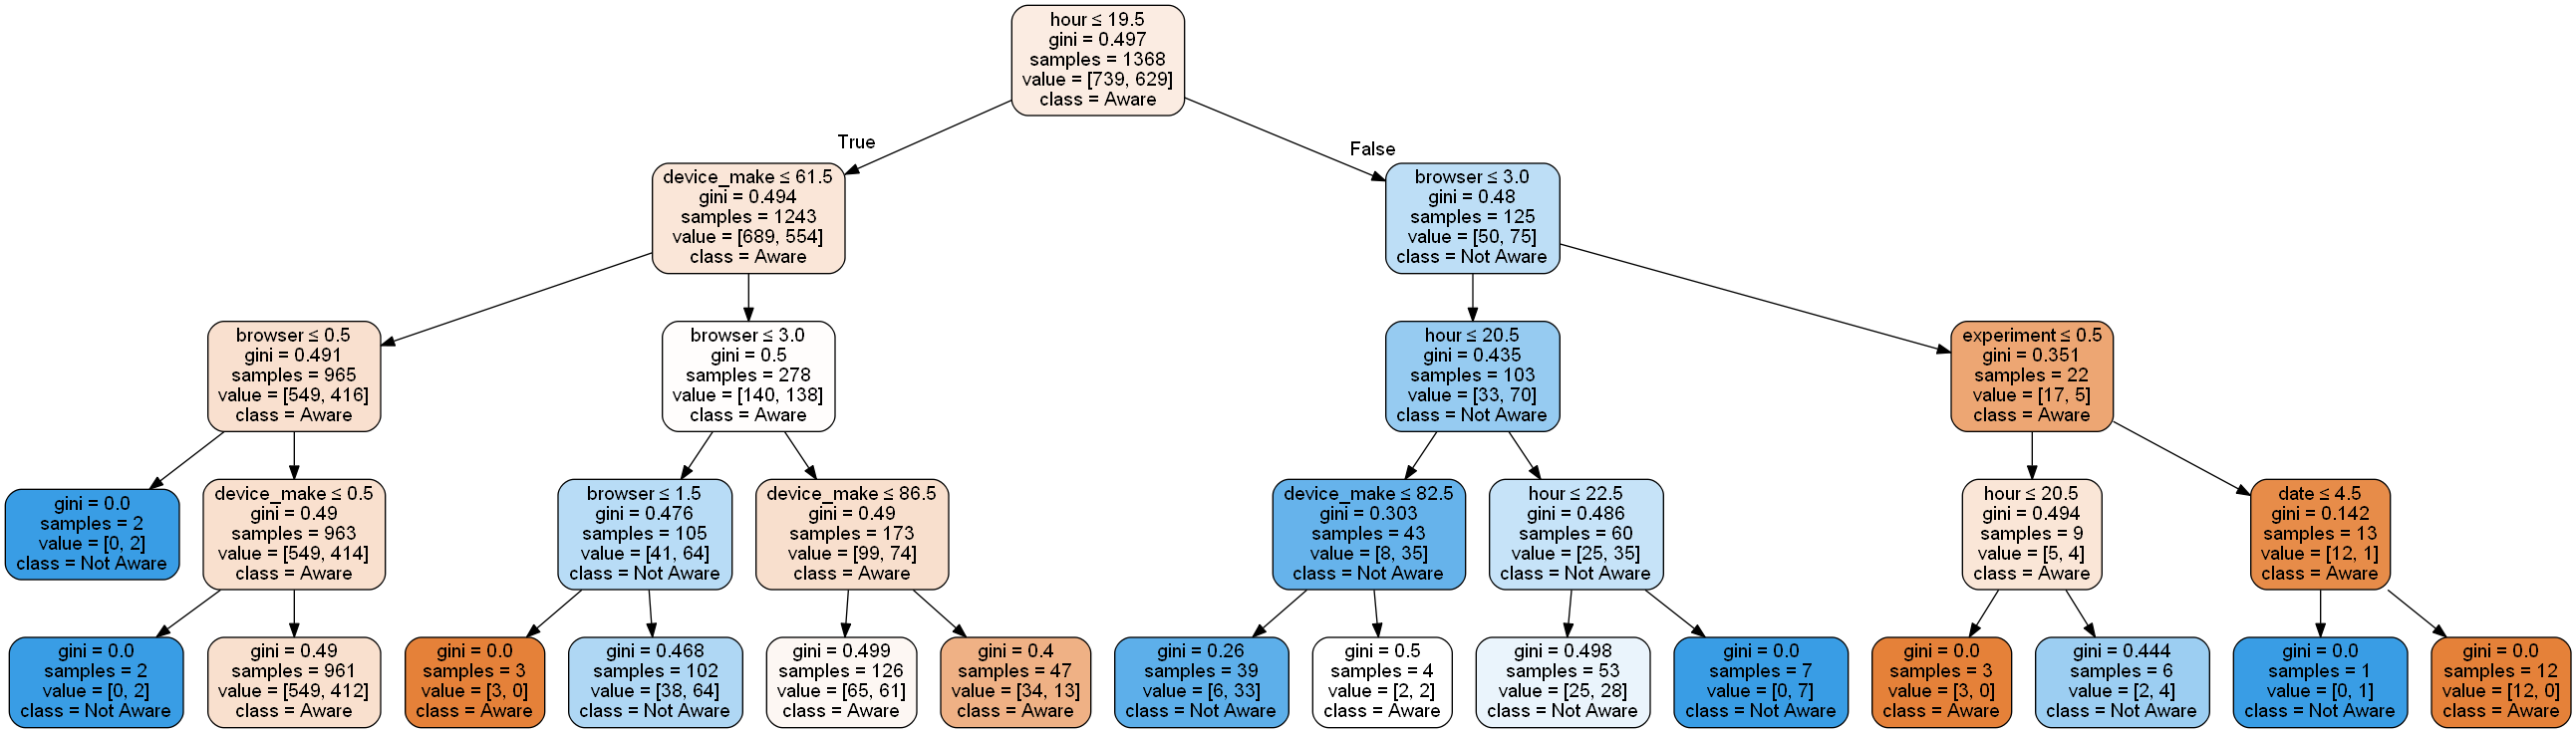

In [79]:
#visualization
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('browser_AbTestDecisionTree.png')

Image(graph.create_png())

## Logistic Regression

### using Browser

In [52]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [53]:
logisticRegressionModel = Logistic(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logisticRegressionModel.train(folds)

step 0: Validation Accuracy of LogesticRegression is: 0.547
step 0: Validation Loss of LogesticRegression is: 0.673

step 1: Validation Accuracy of LogesticRegression is: 0.547
step 1: Validation Loss of LogesticRegression is: 0.673

step 2: Validation Accuracy of LogesticRegression is: 0.520
step 2: Validation Loss of LogesticRegression is: 0.692

step 3: Validation Accuracy of LogesticRegression is: 0.591
step 3: Validation Loss of LogesticRegression is: 0.640

step 4: Validation Accuracy of LogesticRegression is: 0.585
step 4: Validation Loss of LogesticRegression is: 0.644



step 1: Test Accuracy of LogesticRegression is: 0.542
Test Metrics
              precision    recall  f1-score   support

           0       0.92      0.54      0.68       172
           1       0.11      0.56      0.19        18

    accuracy                           0.54       190
   macro avg       0.52      0.55      0.43       190
weighted avg       0.84      0.54      0.63       190



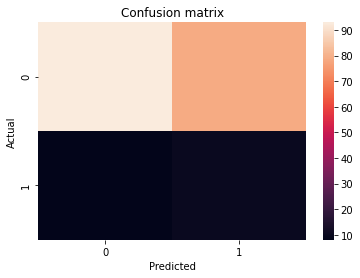

In [54]:
test_acc2, test_loss2, report2, matrix2  = logisticRegressionModel.test()

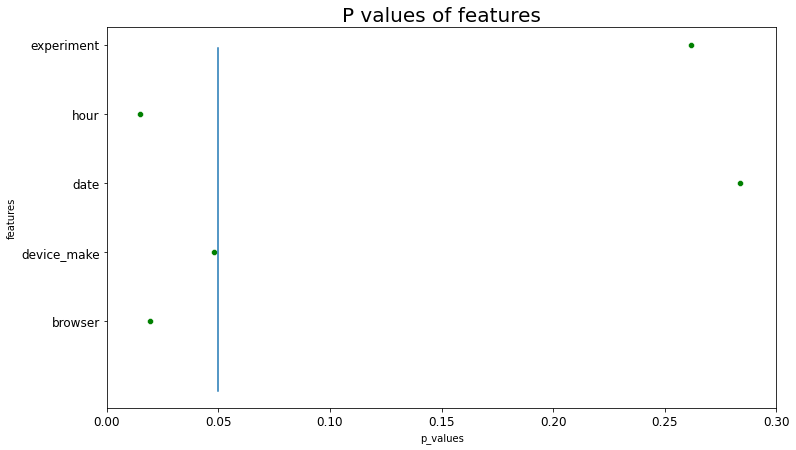

,features,p_values
0,experiment,0.261734
1,hour,0.014902
2,date,0.283877
3,device_make,0.048059
4,browser,0.019462


In [55]:
p_values_df = logisticRegressionModel.get_p_values()
p_value_fig = logisticRegressionModel.plot_pvalues(p_values_df)
p_values_df


### using Platform

In [56]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [57]:
logesticRegressionModel = Logistic(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(folds)

step 0: Validation Accuracy of LogesticRegression is: 0.523
step 0: Validation Loss of LogesticRegression is: 0.690

step 1: Validation Accuracy of LogesticRegression is: 0.520
step 1: Validation Loss of LogesticRegression is: 0.692

step 2: Validation Accuracy of LogesticRegression is: 0.538
step 2: Validation Loss of LogesticRegression is: 0.680

step 3: Validation Accuracy of LogesticRegression is: 0.579
step 3: Validation Loss of LogesticRegression is: 0.649

step 4: Validation Accuracy of LogesticRegression is: 0.550
step 4: Validation Loss of LogesticRegression is: 0.671



step 1: Test Accuracy of LogesticRegression is: 0.521
Test Metrics
              precision    recall  f1-score   support

           0       0.93      0.53      0.67       178
           1       0.06      0.42      0.10        12

    accuracy                           0.52       190
   macro avg       0.49      0.47      0.39       190
weighted avg       0.88      0.52      0.64       190



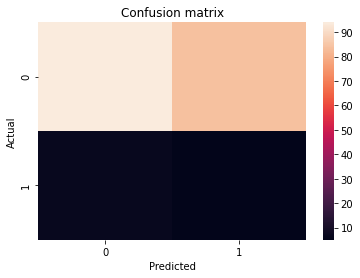

In [58]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

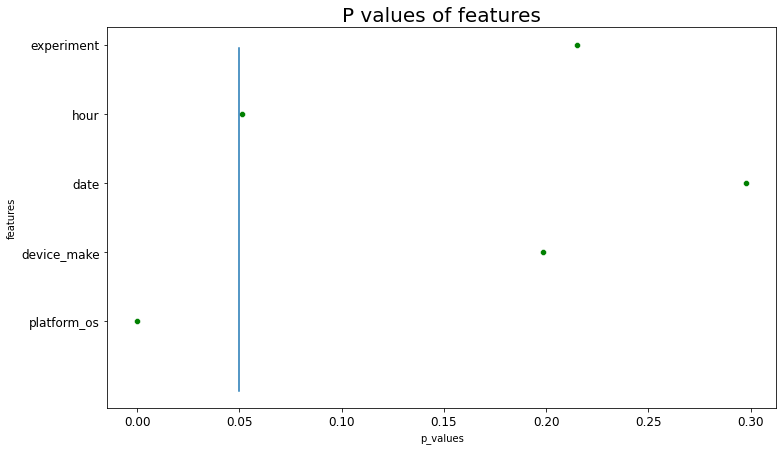

,features,p_values
0,experiment,2.152812e-01
1,hour,5.124562e-02
2,date,2.977040e-01
3,device_make,1.982476e-01
4,platform_os,7.509035e-123


In [59]:
p_values_df = logesticRegressionModel.get_p_values()
p_value_fig = logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df

## XGBOOST

### by browser

In [60]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'browser']

X = browser_df[feature_cols]
y = browser_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [61]:
xGBClassifierModel = boost(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = xGBClassifierModel.train(folds)

step 0: Validation Accuracy of GradientBoostingClassifier is: 0.588
step 0: Validation Loss of GradientBoostingClassifier is: 0.642

step 1: Validation Accuracy of GradientBoostingClassifier is: 0.617
step 1: Validation Loss of GradientBoostingClassifier is: 0.619

step 2: Validation Accuracy of GradientBoostingClassifier is: 0.576
step 2: Validation Loss of GradientBoostingClassifier is: 0.651

step 3: Validation Accuracy of GradientBoostingClassifier is: 0.602
step 3: Validation Loss of GradientBoostingClassifier is: 0.631

step 4: Validation Accuracy of GradientBoostingClassifier is: 0.605
step 4: Validation Loss of GradientBoostingClassifier is: 0.628



step 1: Test Accuracy of GradientBoostingClassifier is: 0.611
Test Metrics
              precision    recall  f1-score   support

           0       0.85      0.59      0.70       145
           1       0.34      0.67      0.45        45

    accuracy                           0.61       190
   macro avg       0.59      0.63      0.57       190
weighted avg       0.73      0.61      0.64       190

Loss on test data is: 0.624



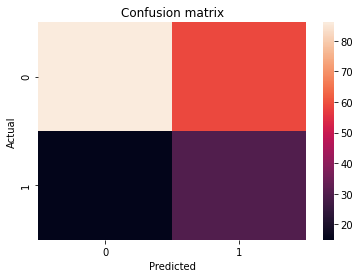

In [62]:
est_acc, loss, report, confusion_matrix = xGBClassifierModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [63]:
xGBClassifierModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.039166
1,hour,0.299479
2,date,0.116415
3,device_make,0.412777
4,browser,0.132163


### by Platform

In [64]:
feature_cols = ["experiment", "hour", "date", 'device_make', 'platform_os']

X = platform_df[feature_cols]
y = platform_df[['response']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [65]:
xGBClassifierModel = boost(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = xGBClassifierModel.train(folds)

step 0: Validation Accuracy of GradientBoostingClassifier is: 0.591
step 0: Validation Loss of GradientBoostingClassifier is: 0.640

step 1: Validation Accuracy of GradientBoostingClassifier is: 0.599
step 1: Validation Loss of GradientBoostingClassifier is: 0.633

step 2: Validation Accuracy of GradientBoostingClassifier is: 0.547
step 2: Validation Loss of GradientBoostingClassifier is: 0.673

step 3: Validation Accuracy of GradientBoostingClassifier is: 0.614
step 3: Validation Loss of GradientBoostingClassifier is: 0.621

step 4: Validation Accuracy of GradientBoostingClassifier is: 0.585
step 4: Validation Loss of GradientBoostingClassifier is: 0.644



step 1: Test Accuracy of GradientBoostingClassifier is: 0.568
Test Metrics
              precision    recall  f1-score   support

           0       0.84      0.56      0.67       151
           1       0.26      0.59      0.36        39

    accuracy                           0.57       190
   macro avg       0.55      0.58      0.52       190
weighted avg       0.72      0.57      0.61       190

Loss on test data is: 0.657



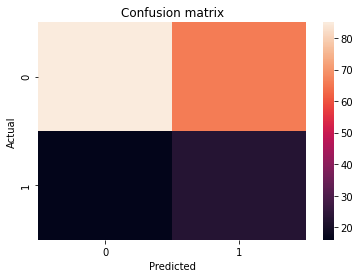

In [66]:
test_acc, loss, report, confusion_matrix = xGBClassifierModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()

## Random Forest

In [76]:

from sklearn.ensemble import RandomForestClassifier

random = RandomForestClassifier(n_estimators=100)
random.fit(X_train, y_train)

# Then predict results from X_test data
prediction = random.predict(X_test)

# See First 10 Predictions and They Actual Values
print("Predicted:", pred_rf[0:10])
print("Actual:", y_test[0:10])

Predicted: [0 0 0 1 0 1 0 0 0 0]
Actual:       response
1222         0
111          0
554          1
526          0
1310         1
1100         1
70           1
251          1
1314         0
1029         1


# Hyperparamerter Tuning for Decision Tree